# GROUP PROJECT: LOAN APPROVAL PREDICTION 

## Members:
- Manuela N
- Daniela S
- Samir MS
- Ibrahima T
- Adam C

## PROJECT STEPS
1. Data importation and exploration
2. Data cleaning
3. Data visualisation
4. Data encoding
5. Selection of sensitive data and fairness metrics
6. Training of the model
7. Evaluation of the model
8. Fairness Evaluation
9.  Bias mitigation
10. Conclusion

## DATA DESCRIPTION
○ Demographics: - Gender (Female, male)

                - Married (Yes, No)
  
                - Dependents (0, 1, 2, 3+)
  
                - Education (Graduate, Not graduated)
  
                - Self_Employed (No, Yes)
  
                - Property_Area (Urban, Rural, Semiurban)

○ Financial information: - ApplicantIncome

                         - CoapplicantIncome
  
                         - Credit_History
  
○ Loan details: - LoanAmount

                - Loan_Amount_Term

○ Target variable: Loan_Status

# IMPORTATION OF LIBRAIRIES

In [294]:
# Remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Generic
import pandas as pd
# Dataset
from ucimlrepo import fetch_ucirepo

# ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import matplotlib.pyplot as plt
#visualisation
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots

import dalex as dx
from dalex.fairness import resample, reweight
from dalex.fairness import roc_pivot

from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import TruePositiveRateParity, DemographicParity, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer

# DATA EXPLORATION

In [295]:
df = pd.read_csv("project-data.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [296]:
# Statistics of numerics variables
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [297]:
# Informations about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [298]:
# Checking of missing values
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

# DATA CLEANING

In [299]:
# Drop missing values
df.dropna(inplace=True)
df.isna().sum().sum()

0

# DATA VISUALISATION

In [300]:
# Function to generate visualizations for categorical variables
def plot_categorical_variable(df, column):
    # Pie chart
    counts = df[column].value_counts()
    fig_pie = px.pie(
        names=counts.index, 
        values=counts.values, 
        title=f'Distribution of {column}',
        hole=0.3,
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
    fig_pie.update_traces(textinfo='percent+label')
    
    return fig_pie

# Generate visualizations for each categorical variable
categorical_vars = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
visualizations = {var: plot_categorical_variable(df, var) for var in categorical_vars}

# Function to analyze Loan_Status based on other variables
def plot_loan_status_breakdown(df, vars_to_analyze):
    # Create a grid of subplots
    fig = make_subplots(
        rows=len(vars_to_analyze), 
        cols=1, 
        subplot_titles=[f'Distribution of Loan Status by {var}' for var in vars_to_analyze],
        vertical_spacing=0.1
    )
    
    # Colors for Loan_Status
    colors = {'Y': 'green', 'N': 'red'}
    
    # For each variable
    for i, var in enumerate(vars_to_analyze, 1):
        # Group data by variable and loan status
        grouped = df.groupby([var, 'Loan_Status']).size().unstack(fill_value=0)
        
        # Create stacked bar charts
        for status in ['Y', 'N']:
            trace = go.Bar(
                x=grouped.index, 
                y=grouped[status], 
                name=f'Loan Status {status}', 
                marker_color=colors[status],
                text=grouped[status],
                textposition='inside'
            )
            fig.add_trace(trace, row=i, col=1)
        
        # Update axes layout
        fig.update_xaxes(title_text=var, row=i, col=1)
        fig.update_yaxes(title_text='Number of Loans', row=i, col=1)
    
    # Update layout
    fig.update_layout(
        height=300 * len(vars_to_analyze), 
        title_text='Loan Status Breakdown by Variables',
        barmode='stack'
    )
    
    return fig

# Variables to analyze
vars_to_analyze = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Generate the loan status breakdown chart
loan_status_breakdown = plot_loan_status_breakdown(df, vars_to_analyze)

print("### Detailed Statistics ###")
for var in categorical_vars:
    print(f"\n{var} :")
    print(df[var].value_counts())
    print(df[var].value_counts(normalize=True).map('{:.2%}'.format))
    
    # Display pie chart visualization
    print(f"\nVisualization of {var} :")
    visualizations[var].show()

# Display loan status breakdown chart
print("\nLoan Status Breakdown by Variables:")
loan_status_breakdown.show()


### Detailed Statistics ###

Gender :
Gender
Male      394
Female     86
Name: count, dtype: int64
Gender
Male      82.08%
Female    17.92%
Name: proportion, dtype: object

Visualization of Gender :



Married :
Married
Yes    311
No     169
Name: count, dtype: int64
Married
Yes    64.79%
No     35.21%
Name: proportion, dtype: object

Visualization of Married :



Dependents :
Dependents
0     274
2      85
1      80
3+     41
Name: count, dtype: int64
Dependents
0     57.08%
2     17.71%
1     16.67%
3+     8.54%
Name: proportion, dtype: object

Visualization of Dependents :



Education :
Education
Graduate        383
Not Graduate     97
Name: count, dtype: int64
Education
Graduate        79.79%
Not Graduate    20.21%
Name: proportion, dtype: object

Visualization of Education :



Self_Employed :
Self_Employed
No     414
Yes     66
Name: count, dtype: int64
Self_Employed
No     86.25%
Yes    13.75%
Name: proportion, dtype: object

Visualization of Self_Employed :



Property_Area :
Property_Area
Semiurban    191
Urban        150
Rural        139
Name: count, dtype: int64
Property_Area
Semiurban    39.79%
Urban        31.25%
Rural        28.96%
Name: proportion, dtype: object

Visualization of Property_Area :



Loan_Status :
Loan_Status
Y    332
N    148
Name: count, dtype: int64
Loan_Status
Y    69.17%
N    30.83%
Name: proportion, dtype: object

Visualization of Loan_Status :



Loan Status Breakdown by Variables:


## Analysis for gender
In our dataset, we have 82.08% of male and 17.92% of female. 

For female, we have 62.79% who have had loans accepted.

For male, we have 70.55% who have had loans accepted.

## Analysis for married 
In our dataset, we have 64.79% of yes and 35.21% of no.

For married, we have 72.99% who have had loans accepted.

For not married, we have 62.13% who have had loans accepted.

## Analysis for Dependents 
In our dataset, we have 57.08% of 0,  17.71% of 2, 16.67% of 1 and 8.54% of 3+

For 0, we have 75.70% who have had loans accepted.

For 1, we have 65% who have had loans accepted.

For 2, we have 76.47% who have had loans accepted.

For 3+, we have 68.29% who have had loans accepted.

## Analysis for Education 
In our dataset, we have 79.79% of Graduate and 20.21% of Not Graduate. 

For graduated, we have 70.75% who have had loans accepted.

For not graduated, we have 62.88% who have had loans accepted.

## Analysis for Self_Employed
In our dataset, we have 13.75% of yes and 86.25% of no.    

For yes, we have 65.15% who have had loans accepted.

For no, we have 69.80% who have had loans accepted.

## Analysis for Property_Area 
In our dataset, we have 39.79% of Semiurban,  31.25% of Urban and 28.96% of Rural.

For Semiurban, we have 78.01% who have had loans accepted.

For Urban, we have 65.33% who have had loans accepted.

For Rural, we have 61.15% who have had loans accepted.

## Analysis for Loan_Status
In our dataset, we have 69.17% of Y and 30.83% of N. 

### In fact, the data is not balanced

## Data Preprocessing

In [301]:
# Remove the ID column
df = df.drop(columns=["Loan_ID"])
# Encoding the target column
df["Loan_Status_bin"] = (df["Loan_Status"]
                    .map({"Y":1, "N":0})
                    .astype(int))

# Drop the initial target column
df.drop(columns=["Loan_Status"], inplace=True)

In [302]:
target = "Loan_Status_bin"

# Split into train and test and initialize preprocessor
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=[target]),
    df[target],
    test_size=0.3,
    random_state=43)

preprocessor = make_column_transformer(
    ("passthrough", make_column_selector(dtype_include=int)),
    (StandardScaler(), make_column_selector(dtype_include=float)),
    (OrdinalEncoder(), make_column_selector(dtype_include=object))
)

# Train preprocessor and transform data
X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train),
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_train.index)
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test),
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_test.index)


# Fairness

### Sensitive attribute
The sensitive attribute is the attribute that we want to protect. In this case, it is the attribute `Gender` because it is highly unbalanced ( 82% for male as opposed to 18% for female) so we'll try and see if the model is biased or not

### Fairness metric
The fairness metric is used to measure the difference in the accuracy of the model for different groups. Our fairness metric for the Gender will be the ``Demographic Parity``. We chose it because we want to ensure that the probability of receiving a loan approval is the same across gender groups, in order to avoid systemic bias.

In [303]:
# Defining protected attributes
protected_attribute = "Gender" 

# Choose the privileged group
privileged = "Male" 

protected_train = X_train[protected_attribute]
protected_test = X_test[protected_attribute]

### Baseline Model

In [304]:
# Train the Baseline Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_preprocessed, y_train)

C:\Users\thioy\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [305]:
# Algorithmic performance
print(classification_report(y_test, logistic_model.predict(X_test_preprocessed)))

              precision    recall  f1-score   support

           0       0.94      0.55      0.69        53
           1       0.79      0.98      0.87        91

    accuracy                           0.82       144
   macro avg       0.86      0.76      0.78       144
weighted avg       0.84      0.82      0.81       144



In [306]:
# Fairness evaluation
exp_logistic_base = dx.Explainer(logistic_model, X_test_preprocessed,
                                     y_test, verbose=True)

fairness_logistic_base = exp_logistic_base.model_fairness(protected=protected_test,
                                                                  privileged=privileged,
                                                                  label="logistic_base")
fairness_logistic_base.fairness_check()
plt.figure(figsize=(15, 15))
fairness_logistic_base.plot()
plt.show()

Preparation of a new explainer is initiated

  -> data              : 144 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 144 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000024FA30E7CA0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0934, mean = 0.66, max = 0.883
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.871, mean = -0.0285, max = 0.898
  -> model_info        : package sklearn

A new explainer has been created!
Bias detected in 1 metric: FPR

Conclusion: your model cannot be called fair because 1 criterion exceeded acc

<Figure size 1500x1500 with 0 Axes>

In [307]:
fairness_logistic_base.plot(type='metric_scores')

### Analysis
Since our fairness metric is the ``STP``, we can say that our model is fair towards Female subjects as the metric is in an acceptable zone. We'll try to see if we can mitigate more the bias since females are still unfavoured compared to males.

# Pre-Processing

### Naive pre-processing: we're going to remove the protected attribute to verify if is correlated with the target variable

In [308]:
# Remove the protected attributes
X_train_restricted = X_train.drop(columns=[protected_attribute])
X_test_restricted = X_test.drop(columns=[protected_attribute])

X_train_preprocessed_restricted = pd.DataFrame(preprocessor.fit_transform(X_train),
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_train_restricted.index)
X_test_preprocessed_restricted = pd.DataFrame(preprocessor.transform(X_test),
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_test_restricted.index)

# Train a Decision Tree on data without protected attributes
clf_logistic_restricted = LogisticRegression()
clf_logistic_restricted.fit(X_train_preprocessed_restricted, y_train)

C:\Users\thioy\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [309]:
# Algorithmic performance
print(classification_report(y_test, clf_logistic_restricted.predict(X_test_preprocessed_restricted)))

              precision    recall  f1-score   support

           0       0.94      0.55      0.69        53
           1       0.79      0.98      0.87        91

    accuracy                           0.82       144
   macro avg       0.86      0.76      0.78       144
weighted avg       0.84      0.82      0.81       144



In [310]:
# Fairness evaluation
# Let's see the effects of removing protected attributes on bias metrics
exp_logistic_restricted = dx.Explainer(clf_logistic_restricted, X_test_preprocessed_restricted,
                                     y_test, verbose=True)

fairness_logistic_restricted = exp_logistic_restricted.model_fairness(protected=protected_test,
                                                                  privileged=privileged,
                                                                  label="logistic_restricted")
fairness_logistic_restricted.fairness_check()
# plt.figure(figsize=(15, 15))
# fairness_logistic_restricted.plot()
# plt.show()

Preparation of a new explainer is initiated

  -> data              : 144 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 144 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000024FA30E7CA0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0934, mean = 0.66, max = 0.883
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.871, mean = -0.0285, max = 0.898
  -> model_info        : package sklearn

A new explainer has been created!
Bias detected in 1 metric: FPR

Conclusion: your model cannot be called fair because 1 criterion exceeded acc

### Analysis

### Resampling

In [311]:
# Resampling
indices_resampled = resample(protected_train, y_train, type='uniform')
X_train_resampled = X_train_preprocessed.iloc[indices_resampled]
y_train_resampled = y_train.iloc[indices_resampled]              # Use the indices to get the resampled labels

# Fit the Resampled Model
clf_resampled = LogisticRegression()
clf_resampled.fit(X_train_resampled, y_train_resampled)

protected Series will be converted to np.ndarray
protected array is not string type, converting to string 
Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.


C:\Users\thioy\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [312]:
# Algorithmic performance
print(classification_report(y_test, clf_resampled.predict(X_test_preprocessed)))

              precision    recall  f1-score   support

           0       0.94      0.55      0.69        53
           1       0.79      0.98      0.87        91

    accuracy                           0.82       144
   macro avg       0.86      0.76      0.78       144
weighted avg       0.84      0.82      0.81       144



In [313]:
# Fairness evaluation
exp_logistic_resampled = dx.Explainer(clf_resampled, X_test_preprocessed,
                                     y_test, verbose=True)

fairness_logistic_resampled= exp_logistic_resampled.model_fairness(protected=protected_test,
                                                                  privileged=privileged,
                                                                  label="logistic_resampled")
fairness_logistic_resampled.fairness_check()
# plt.figure(figsize=(15, 15))
# fairness_logistic_resampled.plot()

Preparation of a new explainer is initiated

  -> data              : 144 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 144 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000024FA30E7CA0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0555, mean = 0.661, max = 0.902
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.887, mean = -0.0294, max = 0.944
  -> model_info        : package sklearn

A new explainer has been created!
Bias detected in 1 metric: FPR

Conclusion: your model cannot be called fair because 1 criterion exceeded ac

### Analysis

### Reweighting

In [314]:
# Reweighting
weights = reweight(protected_train, y_train, verbose = False)

# Train the Reweighted Model
clf_weighted = LogisticRegression()
clf_weighted.fit(X_train_preprocessed,y_train, sample_weight=weights)

C:\Users\thioy\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [315]:
# Algorithmic performance
print(classification_report(y_test, clf_weighted.predict(X_test_preprocessed)))

              precision    recall  f1-score   support

           0       0.91      0.55      0.68        53
           1       0.79      0.97      0.87        91

    accuracy                           0.81       144
   macro avg       0.85      0.76      0.77       144
weighted avg       0.83      0.81      0.80       144



In [316]:
# Evaluate fairness in comparison to the privileged group
exp_logistic_weighted = dx.Explainer(clf_weighted, X_test_preprocessed,
                                     y_test, verbose=True)

fairness_logistic_weighted = exp_logistic_weighted.model_fairness(protected=protected_test,
                                                                  privileged=privileged,
                                                                  label="logistic_weighted")
fairness_logistic_weighted.fairness_check()
# plt.figure(figsize=(15, 15))
# fairness_logistic_weighted.plot()
# plt.show()

Preparation of a new explainer is initiated

  -> data              : 144 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 144 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000024FA30E7CA0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0672, mean = 0.655, max = 0.889
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.874, mean = -0.0235, max = 0.933
  -> model_info        : package sklearn

A new explainer has been created!
Bias detected in 1 metric: FPR

Conclusion: your model cannot be called fair because 1 criterion exceeded ac

### Analysis

## Fairness models comparison for preprocessing

In [317]:
# Plotting all the previous fairness metrics
fairness_logistic_base.plot([fairness_logistic_restricted,fairness_logistic_resampled,fairness_logistic_weighted])

In [318]:
fairness_logistic_base.plot([fairness_logistic_restricted,fairness_logistic_resampled,fairness_logistic_weighted],type='metric_scores')

### Analysis
The different models result are similar to the base one. But we have better results for the restricted model in terms of accuracy for the STP.

# In-Processing

In [319]:
constraint = DemographicParity()
clf_regularized = LogisticRegression()
bias_reducer = ExponentiatedGradient(clf_regularized, constraint)
bias_reducer.fit(X_train_preprocessed, y_train, sensitive_features=protected_train)

C:\Users\thioy\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\thioy\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Use

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x0000024FB4DBC3D0>,
                      estimator=LogisticRegression(), nu=0.010790700710936794)

In [320]:
# Algorithmic performance
print(classification_report(y_test, bias_reducer.predict(X_test_preprocessed)))

              precision    recall  f1-score   support

           0       0.94      0.55      0.69        53
           1       0.79      0.98      0.87        91

    accuracy                           0.82       144
   macro avg       0.86      0.76      0.78       144
weighted avg       0.84      0.82      0.81       144



In [321]:
exp_logistic_regularized = dx.Explainer(bias_reducer, X_test_preprocessed,
                                     y_test, verbose=True)

fairness_logistic_regularized= exp_logistic_regularized.model_fairness(protected=protected_test,
                                                                  privileged=privileged,
                                                                  label="logistic_regularized")
fairness_logistic_regularized.fairness_check()
plt.figure(figsize=(15, 15))
fairness_logistic_regularized.plot()

Preparation of a new explainer is initiated

  -> data              : 144 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 144 values
  -> model_class       : fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000024FA30E7D30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.785, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.153, max = 1.0
  -> model_info        : package fairlearn

A new explainer has been created!
No bias was detected!

Conclusion: your model is fair in terms of checked fairness cri

<Figure size 1500x1500 with 0 Axes>

### Analysis

Independence,also known as Demographic Parity, measures whether the predictions are independent of the sensitive attribute (e.g., gender).
In this graph, the score is superior to 1 for the "Female" subgroup, indicating that the model's predictions are proportional to the representation of females in the dataset.

Separation, also known as Equalized Odds measures whether the model has equal True Positive Rates and False Positive Rates across groups.

Sufficiency measures whether the predicted probabilities (scores) are calibrated equally across subgroups.

Since we're interested in the Demographic Parity, we can see that females, despite being underrepresented, still are receiving positive outcomes slightly more often than males relative to their representation.

## Post-Processing

In [322]:
# Define and fit the new estimator
clf_decisiontree_threshold = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
clf_decisiontree_threshold.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10)

In [323]:
# Get the threshold chosen for each group
constraint = "demographic_parity"
post_process_est = ThresholdOptimizer(estimator=clf_decisiontree_threshold,
                                      constraints=constraint,
                                      objective="accuracy_score",
                                      prefit=True,
                                      predict_method= 'predict')
post_process_est.fit(X_train_preprocessed, y_train, sensitive_features=protected_train)

ThresholdOptimizer(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=10),
                   predict_method='predict', prefit=True)

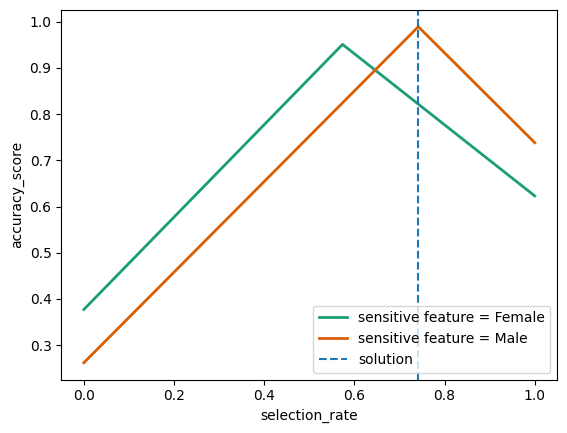

In [324]:
# Visualize the choice of the threshold
plot_threshold_optimizer(post_process_est)

### Analysis
Since we have a threshold of approximately 0.75 which means that 25% of the models results are rejected in order to favor Demographic Parity 

In [325]:
# Algorithmic performance
print(classification_report(y_test, post_process_est.predict(X_test_preprocessed,sensitive_features=protected_test)))

              precision    recall  f1-score   support

           0       0.59      0.49      0.54        53
           1       0.73      0.80      0.76        91

    accuracy                           0.69       144
   macro avg       0.66      0.65      0.65       144
weighted avg       0.68      0.69      0.68       144



In [326]:
# Define a predict function compatible with the Dalex librairy
# Only compatible if you choose sex for the protected attribute
def predict_aux(tree_model, X):

    return tree_model.predict(X,
                              sensitive_features=X['ordinalencoder__Gender'].apply(lambda x : 'Male' if x==1.0 else 'Female'),
                              random_state=42)


In [327]:
# Fairness evaluation
exp_decisiontree_threshold = dx.Explainer(post_process_est, X_test_preprocessed,
                                     y_test, verbose=True,predict_function=predict_aux)

fairness_decisiontree_threshold= exp_decisiontree_threshold.model_fairness(protected=protected_test,
                                                                  privileged=privileged,
                                                                  label="Logistic_threshold",
)
fairness_decisiontree_threshold.fairness_check()
plt.figure(figsize=(15, 15))
fairness_decisiontree_threshold.plot()
plt.show()

Preparation of a new explainer is initiated

  -> data              : 144 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 144 values
  -> model_class       : fairlearn.postprocessing._threshold_optimizer.ThresholdOptimizer (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function predict_aux at 0x0000024FB02788B0> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.715, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.0833, max = 1.0
  -> model_info        : package fairlearn

A new explainer has been created!
No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of

<Figure size 1500x1500 with 0 Axes>

In [328]:
fairness_logistic_regularized.plot([fairness_decisiontree_threshold])

### Analysis

Independence,also known as Demographic Parity, measures whether the predictions are independent of the sensitive attribute (e.g., gender).
In this graph, the score is superior to 1 for the "Female" subgroup, indicating that the model's predictions are proportional to the representation of females in the dataset.

Separation, also known as Equalized Odds measures whether the model has equal True Positive Rates and False Positive Rates across groups.

Sufficiency measures whether the predicted probabilities (scores) are calibrated equally across subgroups.

Since we're interested in the Demographic Parity, we can see that females, despite being underrepresented, still are receiving positive outcomes slightly more often than males relative to their representation.

# Final Choice
We finally decided to go with the reweighted model `logistic_weighted` because it gives the best tradeoff between fairness (0.85 STP score) and accuracy (0.82). Even though there is some bias towards the male, we consider the model to be acceptable based on the scores.